# Keras 101: Designing your Neural Network - How Many Hidden Layers?

Hopefully you will have followed our walkthrough on understanding the role of adding more neurons to a single hidden layer changes the complexity of the decicion boundaries that are output by the neural network for simple classification.

We stared with the simpliest componant of a neural network the neuron and saw how this describes a linear classifier. We then saw that a single hidden layer with an arbitary number of neurons can be used to generate any decision boundary that can be described with a single mapping of one space onto another.

The next question we look to answer is that of "How many hidden layers does my network need?".

A question you might have is if a single hidden layer can generate any decision boundary that can be described by a single mapping of one space onto another is there a need for a second layer? In reality it is rare to find a problem that requires more than a single hidden layer, if you find yourself in a situation where you feel like you require more you should carefully consider if there is anything else you haven't addressed in relation to how you are training your network or the framing of the problem you are trying to solve.

So after that disclaimer onto adding more hidden layers.

We then saw how adding multiple nurons to a single hidden layer results in a decision boundary that is the sum of multiple linear boundaries passed through a output neuron for normalisation. Thus allowing for a represention of any single function that maps one finite space onto another. 

Very rare to need more than one hidden layer.

Generate hilly vally data for 2 layer network comparison.

In [479]:
import keras
import matplotlib.pyplot as plt
import numpy as np

We will now explore the effect of adding more hidden layers to our neural network.

As just described a single hidden layer feeding into a neuron is able to represent any single function that maps one finite space onto another resulting in a nonlinear representation of the dataset. Thus adding a second hidden layer results in an array of nonlinear represnetations of the data. 

Thus the network can represent an arbitrary decision boundary to arbitrary accuracy and can approximate any smooth mapping to any accuracy.

In [480]:
import numpy as np
import scipy.ndimage.filters as fi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # This import has side effects required for the kwarg projection='3d' in the call to fig.add_subplot

def gkern2(kernlen=21, nsig=3):
    """Returns a 2D Gaussian kernel array."""

    # create nxn zeros
    inp = np.zeros((kernlen, kernlen))
    # set element at the middle to one, a dirac delta
    inp[kernlen//2, kernlen//2] = 1
    # gaussian-smooth the dirac, resulting in a gaussian filter mask
    guass = fi.gaussian_filter(inp, nsig)/kernlen
    max1 = np.amax(guass)
    gauss = guass/max1
    return gauss

def generateGaussianHill(xmin,xmax,ymin,ymax,spacer,sig):
    
    gauss = gkern2(spacer,sig)
    x =np.arange(xmin,xmax, (np.abs(xmin)+np.abs(xmax))/spacer)
    y = np.arange(ymin, ymax, (np.abs(ymin)+np.abs(ymax))/spacer)
    X, Y = np.meshgrid(x, y)


    features = []
    for x1 in x:
        for y1 in y:
            item = []
            item.append(x1)
            item.append(y1)   
            features.append(np.array(item))

    features = np.array(features)
    labels = gauss.flatten()
    return features, labels


def generateGaussianHillValley(xmin,xmax,ymin,ymax,spacer,sig):
    
    gauss = np.append(gkern2(spacer,9),-1*gkern2(spacer,9),axis=0)
    x =np.arange(xmin,xmax, (np.abs(xmin)+np.abs(xmax))/spacer)
    y = np.arange(ymin, ymax, (np.abs(ymin)+np.abs(ymax))/(2*spacer))
    X, Y = np.meshgrid(x, y)


    features = []
    for x1 in x:
        for y1 in y:
            item = []
            item.append(x1)
            item.append(y1)   
            features.append(np.array(item))

    features = np.array(features)
    labels = gauss.flatten()
    return features, labels


def plotGaussian(labels,xmin,xmax,ymin,ymax,spacerx,spacery):
    x =np.arange(xmin,xmax, (np.abs(xmin)+np.abs(xmax))/spacerx)
    y = np.arange(ymin, ymax, (np.abs(ymin)+np.abs(ymax))/spacery)
    X, Y = np.meshgrid(x, y)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    gaus = labels.reshape(X.shape)
    ax.plot_surface(X, Y, gaus)

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()
    
def lossPlot(loss):
    
    epoch = np.arange(0, len(loss))
    plt.plot(epoch,loss, label='Training Data Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

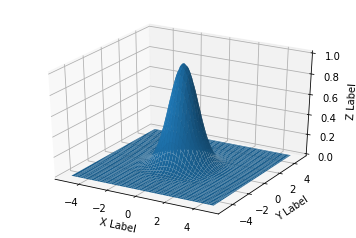

In [470]:
features, labels = generateGaussianHill(-5.0,5.0,-5.0,5.0,100,9)
#features, labels = generateGaussianHillValley(-5.0,5.0,-5.0,5.0,100,9)
plotGaussian(labels,-5.0,5.0,-5.0,5.0,100,100)

In [481]:
layers = []
layers.append(keras.layers.Dense(3, input_dim = 2,activation="sigmoid"))
layers.append(keras.layers.Dense(1,activation="sigmoid"))
layers.append(keras.layers.Dense(1,activation="linear"))
model = keras.Sequential(layers)
print(model.summary())

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_123 (Dense)            (None, 3)                 9         
_________________________________________________________________
dense_124 (Dense)            (None, 1)                 4         
_________________________________________________________________
dense_125 (Dense)            (None, 1)                 2         
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________
None


ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.1), loss='mean_squared_error', metrics=['binary_accuracy', 'categorical_accuracy'])
history = model.fit(features, labels, batch_size=features.shape[0],epochs=1000, verbose=0)
lossPlot(history.history['loss'])

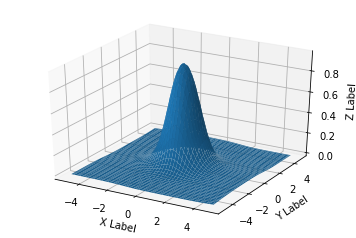

In [473]:
z = model.predict(features)
plotGaussian(z,-5.0,5.0,-5.0,5.0,100,100)

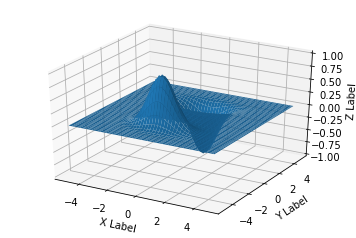

In [475]:
features, labels = generateGaussianHillValley(-5.0,5.0,-5.0,5.0,100,9)
plotGaussian(labels,-5.0,5.0,-5.0,5.0,100,200)

In [415]:
layers = []
layers.append(keras.layers.Dense(50, input_dim = 2, activation="tanh"))
layers.append(keras.layers.Dense(1, activation="linear"))

model = keras.Sequential(layers)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_106 (Dense)            (None, 50)                150       
_________________________________________________________________
dense_107 (Dense)            (None, 1)                 51        
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________
None


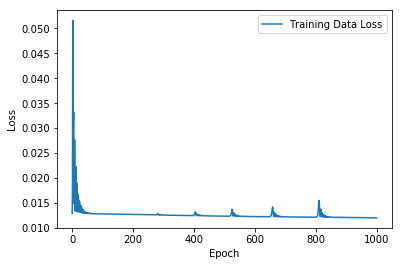

In [420]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.01), loss='mean_squared_error', metrics=['binary_accuracy', 'categorical_accuracy'])
history = model.fit(features, labels, batch_size=features.shape[0],epochs=1000, verbose=0)
lossPlot(history.history['loss'])

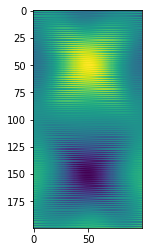

(200, 100)


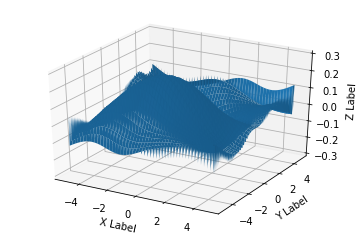

In [419]:
z = model.predict(features)
plotGaussian(z,-5.0,5.0,-5.0,5.0,100,200)

(300, 2)
(1200,)


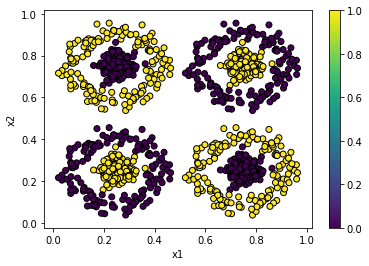

In [3]:
dataset_circle = make_circles(n_samples=300,noise=0.15,factor=0.2, random_state=1)

features_circle = dataset_circle[0]
labels_circle = dataset_circle[1]
labels_circle1 =labels_circle.copy()

features_circle[:,0] = (features_circle[:,0]+1.5)/6.0
features_circle[:,1] = (features_circle[:,1]+1.5)/6.0

features_circle2 = features_circle.copy()
features_circle2[:,0] = features_circle[:,0]+0.5

oneFilter = labels_circle ==1
zeroFilter = labels_circle ==0
labels_circle2 = labels_circle.copy()
labels_circle2[oneFilter] = 0
labels_circle2[zeroFilter] = 1


features_circle3 = features_circle.copy()
features_circle3[:,1] = features_circle[:,1]+0.5

features_circle4 = features_circle.copy()
features_circle4[:,1] = features_circle[:,1]+0.5
features_circle4[:,0] = features_circle[:,0]+0.5



print(features_circle.shape)
features_circle = np.append(features_circle,features_circle2, axis=0)
labels_circle = np.append(labels_circle,labels_circle2, axis=0)
features_circle = np.append(features_circle,features_circle3, axis=0)
labels_circle = np.append(labels_circle,labels_circle2, axis=0)
features_circle = np.append(features_circle,features_circle4, axis=0)
labels_circle = np.append(labels_circle,labels_circle1, axis=0)
print(labels_circle.shape)

x1_min = np.amin(features_circle[:,0])
x1_max = np.amax(features_circle[:,0])
x2_min = np.amin(features_circle[:,1])
x2_max = np.amax(features_circle[:,1])

plt.scatter(features_circle[:,0],features_circle[:,1],edgecolor="black",linewidth=1,c=labels_circle)
plt.xlabel("x1")
plt.ylabel("x2")
plt.colorbar()
plt.show()


layers = []
layers.append(keras.layers.Dense(10, input_dim = 2, activation="sigmoid"))
layers.append(keras.layers.Dense(1, activation="sigmoid"))

model = keras.Sequential(layers)
print(model.summary())
model.compile(optimizer=keras.optimizers.Adam(lr=0.01), loss='binary_crossentropy', metrics=['binary_accuracy', 'categorical_accuracy'])
history = model.fit(features_circle, labels_circle, batch_size=features_circle.shape[0],epochs=6000, verbose=0)

loss = history.history['loss']
epoch = np.arange(0, len(loss))

plt.plot(epoch,loss, label='Training Data Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
xx, yy = np.meshgrid(np.arange(x1_min,x1_max,0.01),np.arange(x2_min,x2_max,0.01))

z = model.predict(np.c_[xx.ravel(),yy.ravel()])
z = z.reshape(xx.shape)

plt.contourf(xx,yy,z)
plt.scatter(features_circle[:,0],features_circle[:,1],c= labels_circle)
plt.xlabel('x1')
plt.ylabel('x2')
plt.colorbar()
plt.show()